NameError: name 'par' is not defined

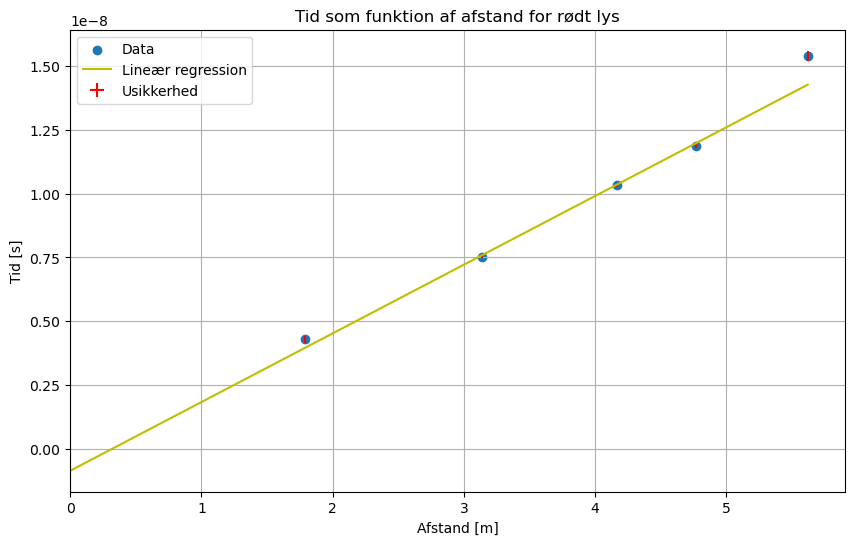

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.optimize import curve_fit
from IPython.display import Markdown as md, display_markdown

red_data_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 8 og 11 - lysets hastighed\grønt lys.xlsx"
red_xls = pd.ExcelFile(red_data_loc)

# Indlæs alle ark i excelfilen som numpy arrays
red_data = [np.array(pd.read_excel(red_xls, sheet_name=sheet)) for sheet in red_xls.sheet_names]
# Indlæs hvert ark som en variabel for sig
red_1 = red_data[0]
red_2 = red_data[1]
red_3 = red_data[2]
red_4 = red_data[3]
red_5 = red_data[4]

# Afstandene er værdien i første række af anden søjle i arket (ganget med 2 for at tage højde for afstanden tilbage til sensoren)
# Enhed [m]
red_1_d = red_1[0][1]*2
red_2_d = red_2[0][1]*2
red_3_d = red_3[0][1]*2
red_4_d = red_4[0][1]*2
red_5_d = red_5[0][1]*2

# Tiderne er de første værdier af hver række i arket ganget med 10**(-9) for at få dem i sekunder
# Enhed [s]
red_1_t = red_1[:,0]*10**(-9)
red_2_t = red_2[:,0]*10**(-9)
red_3_t = red_3[:,0]*10**(-9)
red_4_t = red_4[:,0]*10**(-9)
red_5_t = red_5[:,0]*10**(-9)

# En funktion til at beregne lysets gennemsnitlige hastighed ud fra tiderne og afstandene
def c(times, distances):
    return np.mean(distances/times)

# Usikkerhed for tidsmålingerne
# Enhed [s]
t_unc = 0.1*10**(-9)

# Standardafvigelse for tidsmålinger
# Enhed [s]
red_1_t_std = np.std(red_1_t)
red_2_t_std = np.std(red_2_t)
red_3_t_std = np.std(red_3_t)
red_4_t_std = np.std(red_4_t)
red_5_t_std = np.std(red_5_t)

# Usikkerhed for gennemsnit af tidsmålinger
# Enhed [s]
red_1_t_mean_unc = (red_1_t_std/np.sqrt(red_1_t.size))
red_2_t_mean_unc = (red_2_t_std/np.sqrt(red_2_t.size))
red_3_t_mean_unc = (red_3_t_std/np.sqrt(red_3_t.size))
red_4_t_mean_unc = (red_4_t_std/np.sqrt(red_4_t.size))
red_5_t_mean_unc = (red_5_t_std/np.sqrt(red_5_t.size))

# Arrays med afstande og gennemsnitstider

# Tider for rød
# Enhed [m]
red_time_arr = np.array([red_1_t.mean(), red_2_t.mean(), red_3_t.mean(), red_4_t.mean(), red_5_t.mean()])

# Usikkerhed for gennemsnitstider for rød
# Enhed [s]
red_time_unc_arr = np.array([red_1_t_mean_unc, red_2_t_mean_unc, red_3_t_mean_unc, red_4_t_mean_unc, red_5_t_mean_unc])

# Afstande for rød
# Enhed [m]
red_distance_arr = [red_1_d, red_2_d, red_3_d, red_4_d, red_5_d]

# Usikkerhed for afstande for rød
# Enhed [m]
red_d_unc = 0.005

# Lav et scatterplot med afstande på x-aksen og tider på y-aksen
plt.figure(figsize=(10, 6))
plt.title("Tid som funktion af afstand for rødt lys")
plt.xlabel("Afstand [m]")
plt.ylabel("Tid [s]")
plt.scatter(red_distance_arr, red_time_arr, label="Data")
plt.errorbar(red_distance_arr, red_time_arr, xerr=red_d_unc, yerr=red_time_unc_arr, color="red", fmt='none', label="Usikkerhed")
plt.grid()
plt.legend()

# Lav lineær regression med scipy (med usikkerheder)
# Returnerer en tuple med (a, b) hvor a er hældningen og b er skæringen

lin_func = lambda x, a, b: a*x + b
red_par, red_cov = curve_fit(lin_func, red_distance_arr, red_time_arr, sigma=red_time_unc_arr, absolute_sigma=True)

red_lin_sigma = np.sqrt(np.diagonal(red_cov))

red_lin_fit = lambda x: red_par[0]*x + red_par[1]

# Tegn fittet i samme plot som scatterplottet
X = np.linspace(0, max([red_1_d, red_2_d, red_3_d, red_4_d, red_5_d]), 10000)
Y = red_lin_fit(X)
plt.plot(X, Y, color="y", label="Lineær regression")
plt.xlim(0)
plt.legend()

# Gem som png
plt.savefig("red.png", dpi=300)

display_markdown(md(r"Parametrene for det lineære fit: <br> $a = {} \pm {}$, $b = {} \pm {}$".format(red_par[0], red_lin_sigma[0], red_par[1], red_lin_sigma[1])))

display_markdown(md(r"Afrundet og med enheder: <br> $a = ({} \pm {}) \frac{{L}}{{s}}$, $b = ({} \pm {}) L$".format(round(red_par[0], 4), round(red_lin_sigma[0], 4), round(red_par[1], 3), round(red_lin_sigma[1], 3))))





c: 3.534866e+08 m/s


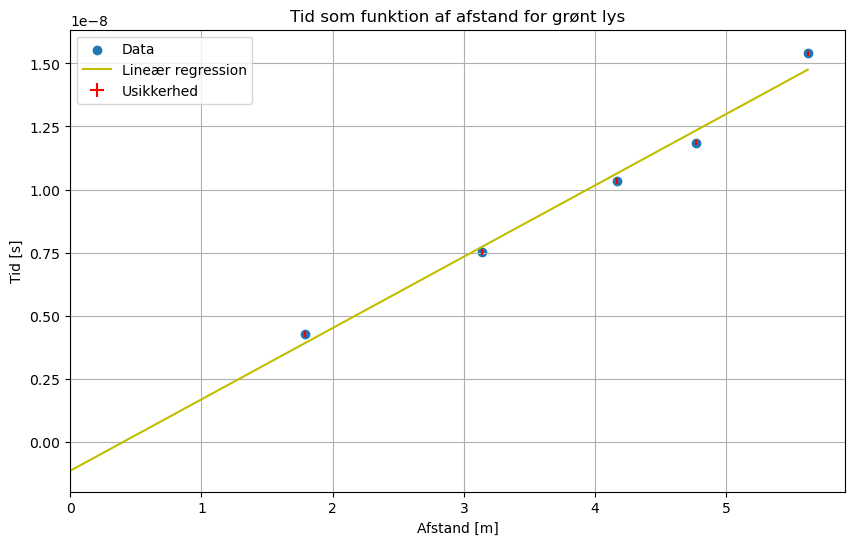

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.optimize import curve_fit

green_data_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 8 og 11 - lysets hastighed\grønt lys.xlsx"
green_xls = pd.ExcelFile(green_data_loc)

# Indlæs alle ark i excelfilen som numpy arrays
green_data = [np.array(pd.read_excel(green_xls, sheet_name=sheet)) for sheet in green_xls.sheet_names]
# Indlæs hvert ark som en variabel for sig
green_1 = green_data[0]
green_2 = green_data[1]
green_3 = green_data[2]
green_4 = green_data[3]
green_5 = green_data[4]

# Afstandene er værdien i første række af anden søjle i arket (ganget med 2 for at tage højde for afstanden tilbage til sensoren)
# Enhed [m]
green_1_d = green_1[0][1]*2
green_2_d = green_2[0][1]*2
green_3_d = green_3[0][1]*2
green_4_d = green_4[0][1]*2
green_5_d = green_5[0][1]*2

# Tiderne er de første værdier af hver række i arket ganget med 10**(-9) for at få dem i sekunder
# Enhed [s]
green_1_t = green_1[:,0]*10**(-9)
green_2_t = green_2[:,0]*10**(-9)
green_3_t = green_3[:,0]*10**(-9)
green_4_t = green_4[:,0]*10**(-9)
green_5_t = green_5[:,0]*10**(-9)

# En funktion til at beregne lysets gennemsnitlige hastighed ud fra tiderne og afstandene
def c(times, distances):
    return np.mean(distances/times)

# Usikkerhed for tidsmålingerne
# Enhed [s]
t_unc = 0.1*10**(-9)

# Standardafvigelse for tidsmålinger
# Enhed [s]
green_1_t_std = np.std(green_1_t)
green_2_t_std = np.std(green_1_t)
green_3_t_std = np.std(green_1_t)
green_4_t_std = np.std(green_1_t)
green_5_t_std = np.std(green_1_t)

# Usikkerhed for gennemsnit af tidsmålinger
# Enhed [s]
green_1_t_mean_unc = np.sqrt((green_1_t_std/green_1_t.size)**2 + t_unc**2)
green_2_t_mean_unc = np.sqrt((green_2_t_std/green_2_t.size)**2 + t_unc**2)
green_3_t_mean_unc = np.sqrt((green_3_t_std/green_3_t.size)**2 + t_unc**2)
green_4_t_mean_unc = np.sqrt((green_4_t_std/green_4_t.size)**2 + t_unc**2)
green_5_t_mean_unc = np.sqrt((green_5_t_std/green_5_t.size)**2 + t_unc**2)

# Arrays med afstande og gennemsnitstider

# Tider for rød
# Enhed [m]
green_time_arr = np.array([green_1_t.mean(), green_2_t.mean(), green_3_t.mean(), green_4_t.mean(), green_5_t.mean()])

# Usikkerhed for gennemsnitstider for rød
# Enhed [s]
green_time_unc_arr = np.array([green_1_t_mean_unc, green_2_t_mean_unc, green_3_t_mean_unc, green_4_t_mean_unc, green_5_t_mean_unc])

# Afstande for rød
# Enhed [m]
green_distance_arr = [green_1_d, green_2_d, green_3_d, green_4_d, green_5_d]

# Usikkerhed for afstande for rød
# Enhed [m]
green_d_unc = 0.005

# Lav et scatterplot med afstande på x-aksen og tider på y-aksen
plt.figure(figsize=(10, 6))
plt.title("Tid som funktion af afstand for grønt lys")
plt.xlabel("Afstand [m]")
plt.ylabel("Tid [s]")
plt.scatter(green_distance_arr, green_time_arr, label="Data")
plt.errorbar(green_distance_arr, green_time_arr, xerr=green_d_unc, yerr=green_time_unc_arr, color="r", fmt='none', label="Usikkerhed")
plt.grid()
plt.legend()

# Lav lineær regression med scipy (med usikkerheder)
# Returnerer en tuple med (a, b) hvor a er hældningen og b er skæringen

lin_func = lambda x, a, b: a*x + b
green_par, green_cov = curve_fit(lin_func, green_distance_arr, green_time_arr, sigma=green_time_unc_arr, absolute_sigma=True)

green_lin_fit = lambda x: green_par[0]*x + green_par[1]

# Tegn fittet i samme plot som scatterplottet
X = np.linspace(0, max([green_1_d, green_2_d, green_3_d, green_4_d, green_5_d]), 10000)
Y = green_lin_fit(X)
plt.plot(X, Y, color="y", label="Lineær regression")
plt.xlim(0)
plt.legend()

print("c: {:e} m/s".format(1/green_par[0]))

# Save as png
plt.savefig("green.png", dpi=300)


458418647.01453745  +/- 3.571515559934571e-11
1.8350944285890904e-09  +/- 1.1568226641242487e-10
c: 4.584186e+08 m/s


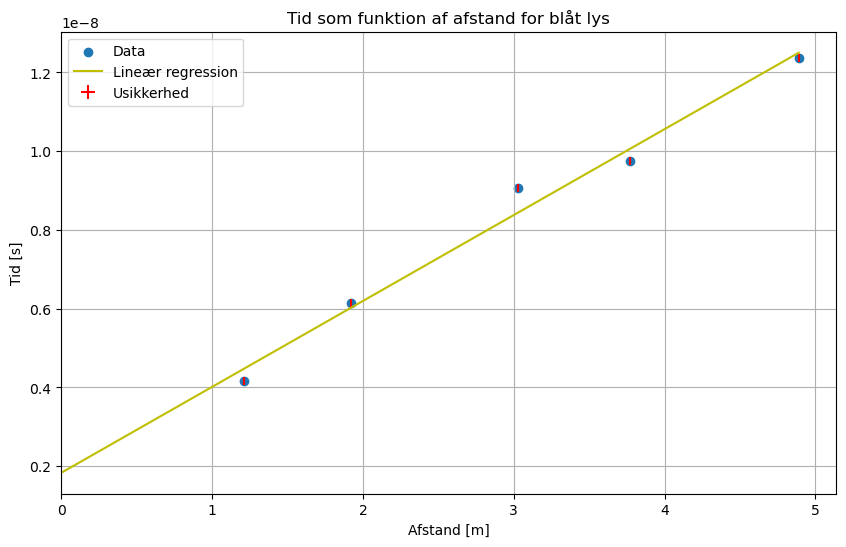

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.optimize import curve_fit

blue_data_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 8 og 11 - lysets hastighed\blåt lys.xlsx"
blue_xls = pd.ExcelFile(blue_data_loc)

# Indlæs alle ark i excelfilen som numpy arrays
blue_data = [np.array(pd.read_excel(blue_xls, sheet_name=sheet)) for sheet in blue_xls.sheet_names]
# Indlæs hvert ark som en variabel for sig
blue_1 = blue_data[0]
blue_2 = blue_data[1]
blue_3 = blue_data[2]
blue_4 = blue_data[3]
blue_5 = blue_data[4]

# Afstandene er værdien i første række af anden søjle i arket (ganget med 2 for at tage højde for afstanden tilbage til sensoren)
# Enhed [m]
blue_1_d = blue_1[0][1]*2
blue_2_d = blue_2[0][1]*2
blue_3_d = blue_3[0][1]*2
blue_4_d = blue_4[0][1]*2
blue_5_d = blue_5[0][1]*2

# Tiderne er de første værdier af hver række i arket ganget med 10**(-9) for at få dem i sekunder
# Enhed [s]
blue_1_t = blue_1[:,0]*10**(-9)
blue_2_t = blue_2[:,0]*10**(-9)
blue_3_t = blue_3[:,0]*10**(-9)
blue_4_t = blue_4[:,0]*10**(-9)
blue_5_t = blue_5[:,0]*10**(-9)

# En funktion til at beregne lysets gennemsnitlige hastighed ud fra tiderne og afstandene
def c(times, distances):
    return np.mean(distances/times)

# Usikkerhed for tidsmålingerne
# Enhed [s]
t_unc = 0.1*10**(-9)

# Standardafvigelse for tidsmålinger
# Enhed [s]
blue_1_t_std = np.std(blue_1_t)
blue_2_t_std = np.std(blue_1_t)
blue_3_t_std = np.std(blue_1_t)
blue_4_t_std = np.std(blue_1_t)
blue_5_t_std = np.std(blue_1_t)

# Usikkerhed for gennemsnit af tidsmålinger
# Enhed [s]
blue_1_t_mean_unc = np.sqrt((blue_1_t_std/blue_1_t.size)**2 + t_unc**2)
blue_2_t_mean_unc = np.sqrt((blue_2_t_std/blue_2_t.size)**2 + t_unc**2)
blue_3_t_mean_unc = np.sqrt((blue_3_t_std/blue_3_t.size)**2 + t_unc**2)
blue_4_t_mean_unc = np.sqrt((blue_4_t_std/blue_4_t.size)**2 + t_unc**2)
blue_5_t_mean_unc = np.sqrt((blue_5_t_std/blue_5_t.size)**2 + t_unc**2)

# Arrays med afstande og gennemsnitstider

# Tider for rød
# Enhed [m]
blue_time_arr = np.array([blue_1_t.mean(), blue_2_t.mean(), blue_3_t.mean(), blue_4_t.mean(), blue_5_t.mean()])

# Usikkerhed for gennemsnitstider for rød
# Enhed [s]
blue_time_unc_arr = np.array([blue_1_t_mean_unc, blue_2_t_mean_unc, blue_3_t_mean_unc, blue_4_t_mean_unc, blue_5_t_mean_unc])

# Afstande for rød
# Enhed [m]
blue_distance_arr = [blue_1_d, blue_2_d, blue_3_d, blue_4_d, blue_5_d]

# Usikkerhed for afstande for rød
# Enhed [m]
blue_d_unc = 0.005

# Lav et scatterplot med afstande på x-aksen og tider på y-aksen
plt.figure(figsize=(10, 6))
plt.title("Tid som funktion af afstand for blåt lys")
plt.xlabel("Afstand [m]")
plt.ylabel("Tid [s]")
plt.scatter(blue_distance_arr, blue_time_arr, label="Data")
plt.errorbar(blue_distance_arr, blue_time_arr, xerr=blue_d_unc, yerr=blue_time_unc_arr, color="r", fmt='none', label="Usikkerhed")
plt.grid()
plt.legend()

# Lav lineær regression med scipy (med usikkerheder)
# Returnerer en tuple med (a, b) hvor a er hældningen og b er skæringen

lin_func = lambda x, a, b: a*x + b
blue_par, blue_cov = curve_fit(lin_func, blue_distance_arr, blue_time_arr, sigma=blue_time_unc_arr, absolute_sigma=True)

blue_lin_fit = lambda x: blue_par[0]*x + blue_par[1]

# Tegn fittet i samme plot som scatterplottet
X = np.linspace(0, max([blue_1_d, blue_2_d, blue_3_d, blue_4_d, blue_5_d]), 10000)
Y = blue_lin_fit(X)
plt.plot(X, Y, color="y", label="Lineær regression")
plt.xlim(0)
plt.legend()

sigma = np.sqrt(np.diagonal(blue_cov))
print(1/blue_par[0], ' +/-' , sigma[0])
print(blue_par[1], ' +/-' , sigma[1])

print("c: {:e} m/s".format(1/blue_par[0]))

# Save as png
plt.savefig("blue.png", dpi=300)
